In [19]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [28]:
import sys
# sys.path.append('/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/DATA_SCIENCE/CODE_REPOSITORY')
from linear_algebra import *
from gradient_descent import *

$ \text{MODEL: } $

$ y_i = f(x_i\beta) + \epsilon_i $

$ p(y_i \mid x_i,\beta) = f(x_i\beta)^{y_i} (1 - f(x_i\beta))^{1-y_i} $

$ \text{logL}(\beta \mid x_i, y_i) = y_i\text{log}f(x_i\beta) + (1-y_i)\text{log}(1-f(x_i\beta)) $

In [10]:
# SIGMOID TRANSFORMATION
def logistic(x):
    return 1.0 / (1 + math.exp(-x))

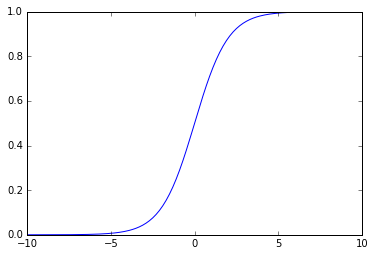

In [21]:
plt.plot(np.arange(-10,10,.1), [logistic(i) for i in np.arange(-10,10,.1)])

In [188]:
# LOGISTIC LOG-LIKELIHOOD (which we'd like to maximize)
#  NB: overall likelihood is the product of individual likelihoods.
#    (log-likelihood, sum of individuals).
def logistic_log_likelihood_i(x_i, y_i, beta):
    if y_i == 1: # i.e. y_true = 1.
        return math.log(logistic(dot(x_i, beta)))
    else:
#         print 'x_i', x_i
#         print 'beta', beta
#         print 'focus: ', 1 - logistic(dot(x_i, beta))
        if (1 - logistic(dot(x_i, beta))) == 0.0: # added to avoid math.log(0.0) error (NB: 1-vs-all).
            return math.log(10e-15)
        else:
            return math.log(1 - logistic(dot(x_i, beta)))
def logistic_log_likelihood(x, y, beta):
    return sum(logistic_log_likelihood_i(x_i, y_i, beta) for x_i,y_i in zip(x,y))

In [189]:
# GRADIENT
def logistic_log_partial_ij(x_i, y_i, beta, j):
    # i: ith data point; j: jth derivative.
    return (y_i - logistic(dot(x_i, beta))) * x_i[j]
def logistic_log_gradient_i(x_i, y_i, beta):
    # gd of the ith data point.
    return [logistic_log_partial_ij(x_i, y_i, beta, j) for j, _ in enumerate(beta)]
        # enumerate on beta, because the number of betas = the number of x's in x_i.
def logistic_log_gradient(x, y, beta):
    return reduce(vector_add, [logistic_log_gradient_i(x_i, y_i, beta) for x_i,y_i in zip(x,y)])

In [198]:
# PREDICTION
def logistic_predict_i(x_i, beta):
    return logistic(dot(x_i, beta))
def logistic_predict(x, beta):
    return [ 1 if logistic_predict_i(x_i, beta) > .5 else 0 for x_i in x]

In [ ]:
# DEMO: CARMPG DATA

In [190]:
os.chdir('/Users/jacobsw/Desktop/IMPLEMENTATION_CAMP/CODE/BASIC_TOPICS/DATA_SCIENCE/DATA')

In [191]:
data = pd.read_csv('carmpg.txt', sep='\s+', 
                   names=['mpg','cylinders','displacement','horsepower',
                          'weight','acceleration','model_year','origin','car_name'])
data.head() # horsepower: 150 cutoff

mpg  cylinders  displacement  horsepower  weight  acceleration  \
0  18.0          8         307.0       130.0  3504.0          12.0   
1  15.0          8         350.0       165.0  3693.0          11.5   
2  18.0          8         318.0       150.0  3436.0          11.0   
3  16.0          8         304.0       150.0  3433.0          12.0   
4  17.0          8         302.0       140.0  3449.0          10.5   

   model_year  origin                   car_name  
0          70       1  chevrolet chevelle malibu  
1          70       1          buick skylark 320  
2          70       1         plymouth satellite  
3          70       1              amc rebel sst  
4          70       1                ford torino

In [192]:
hi_lo_hp = []
for item in data['horsepower']:
    if item > 150.0: hi_lo_hp.append(1)
    else: hi_lo_hp.append(0)
raw = pd.DataFrame([data['mpg'],data['cylinders'],data['acceleration']]).T
raw['hp_class'] = pd.Series(hi_lo_hp)
raw.head()

mpg  cylinders  acceleration  hp_class
0  18.0        8.0          12.0         0
1  15.0        8.0          11.5         1
2  18.0        8.0          11.0         0
3  16.0        8.0          12.0         0
4  17.0        8.0          10.5         0

In [193]:
X_train, X_test, y_train, y_test = train_test_split(raw.ix[:,0:3].as_matrix(), raw.ix[:,3].as_matrix(), test_size=.33)
print X_train.shape, y_train.shape

(266, 3) (266,)


In [194]:
fn = partial(logistic_log_likelihood, X_train, y_train) # leaving beta unfed.
gradient_fn = partial(logistic_log_gradient, X_train, y_train) # leaving beta unfed.
betaInit = [random.random() for _ in range(3)]

In [195]:
%%time
betaHat = maximize_stochastic(logistic_log_likelihood_i, logistic_log_gradient_i, 
                              X_train, y_train, betaInit)

CPU times: user 1.15 s, sys: 19.8 ms, total: 1.17 s
Wall time: 1.16 s


In [204]:
# EVALUATION
yHat = np.array(logistic_predict(X_test, betaHat))
accuracy_score(y_test, yHat)

0.94696969696969702

In [210]:
# CONFUSION MATRIX
#  Op1: Manual
from collections import Counter
print Counter(zip(y_test, yHat))
#  Op2: Automatic
from sklearn.metrics import confusion_matrix, classification_report
print confusion_matrix(y_test, yHat)
print classification_report(y_test, yHat)

Counter({(0, 0): 114, (1, 1): 11, (0, 1): 4, (1, 0): 3})
[[114   4]
 [  3  11]]
             precision    recall  f1-score   support

          0       0.97      0.97      0.97       118
          1       0.73      0.79      0.76        14

avg / total       0.95      0.95      0.95       132

